<a href="https://colab.research.google.com/github/onelgo/onelgo/blob/main/earthquake_with_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

In [ ]:
#import data
df_features = pd.read_csv('/content/Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Values.csv', index_col="building_id")
df_labels = pd.read_csv('/content/Richters_Predictor_Modeling_Earthquake_Damage_-_Train_Labels.csv', index_col="building_id")
df_test = pd.read_csv('/content/Richters_Predictor_Modeling_Earthquake_Damage_-_Test_Values.csv', index_col="building_id")
df_submission = pd.read_csv ('/content/Richters_Predictor_Modeling_Earthquake_Damage_-_Submission_Format.csv', index_col="building_id")

In [ ]:
df = pd.merge(df_features, df_labels, left_index=True, right_index=True)
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [ ]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(260601, 39)

In [ ]:
df.loc[df['geo_level_3_id']==12198][['geo_level_1_id','geo_level_2_id']].head()

,geo_level_1_id,geo_level_2_id
building_id,,
802906,6,487
959468,6,487
215003,6,487
302373,6,487
820534,6,487


In [ ]:
df['geo_level_2_id'].nunique()

1414

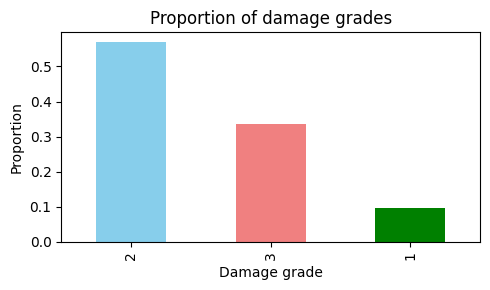

In [ ]:
#draw a graph displaying proportion of the label values

# Calculate proportions for each label
damage_grade_proportion = df['damage_grade'].value_counts(normalize=True)

# Create subplots
plt.figure(figsize=(5, 3))

# Plot proportions for h1n1_vaccine
damage_grade_proportion.plot(kind='bar', color=['skyblue', 'lightcoral', 'green'])
plt.title('Proportion of damage grades')
plt.xlabel('Damage grade')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [ ]:
# Target Encoding Calculate the mean damage grade for each geo_level_3_id
geo_level_3_mapping = df.groupby('geo_level_3_id')['damage_grade'].mean()

# Replace geo_level_3_id with the mean damage grade
df_features['geo_level_3_id'] = df['geo_level_3_id'].map(geo_level_3_mapping)
df_test['geo_level_3_id'] = df_test['geo_level_3_id'].map(geo_level_3_mapping)


In [ ]:
df_features.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,2.837838,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2.062500,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,2.580882,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,2.096774,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,2.368852,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_test.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,2.631579,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,2.000000,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,3.000000,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,1.437788,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,2.823529,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#defining cat column types needed fot CatBoost
cat_columns = df_features.select_dtypes(include='object').columns
cat_columns = cat_columns.union(['geo_level_1_id', 'geo_level_2_id'])
num_columns = df_features.columns.difference(cat_columns)
print(cat_columns)
print(num_columns)

Index(['foundation_type', 'geo_level_1_id', 'geo_level_2_id',
       'ground_floor_type', 'land_surface_condition', 'legal_ownership_status',
       'other_floor_type', 'plan_configuration', 'position', 'roof_type'],
      dtype='object')
Index(['age', 'area_percentage', 'count_families', 'count_floors_pre_eq',
       'geo_level_3_id', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_gov_office', 'has_secondary_use_health_post',
       'has_secondary_use_hotel', 'has_secondary_use_industry',
       'has_secondary_use_institution', 'has_secondary_use_other',
       'has_secondary_use_rental', 'has_secondary_use_school',
       'has_secondary_use_use_police', 'has_superstructure_adobe_mud',
       'has_superstructure_bamboo', 'has_superstructure_cement_mortar_brick',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_other',
       'has_superstructu

208:	learn: 0.6893955	total: 7m 2s	remaining: 26m 39s
152:	learn: 0.6790569	total: 7m 2s	remaining: 38m 56s
122:	learn: 0.6726596	total: 7m 1s	remaining: 50m 7s
209:	learn: 0.6896106	total: 7m 5s	remaining: 26m 40s
126:	learn: 0.6742118	total: 7m 4s	remaining: 48m 40s
153:	learn: 0.6796303	total: 7m 5s	remaining: 38m 55s
123:	learn: 0.6726833	total: 7m 6s	remaining: 50m 9s
210:	learn: 0.6899300	total: 7m 8s	remaining: 26m 41s


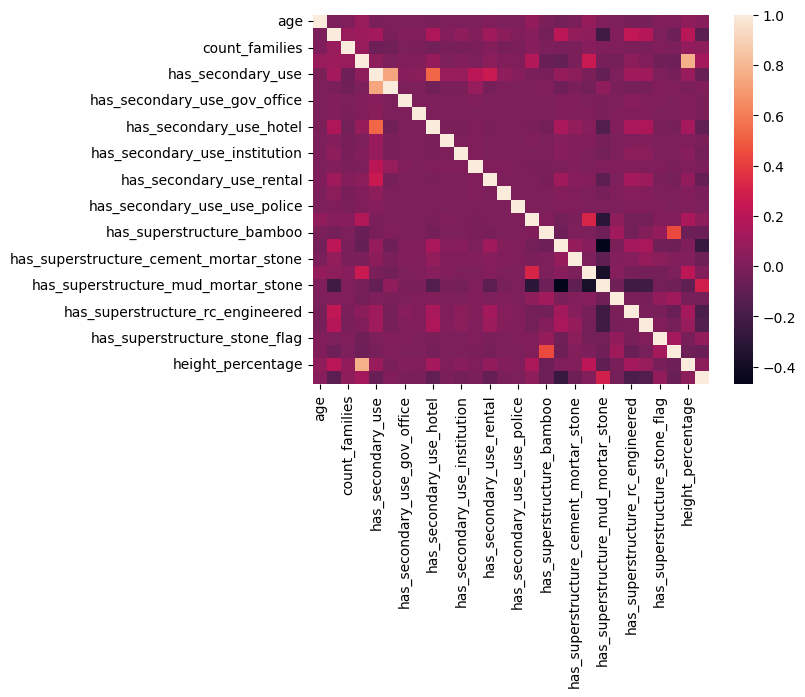

In [ ]:
#correlation heat map
sns.heatmap(df_features[num_columns].join(df_labels).corr(), annot=False, fmt=".2f")
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_features, df_labels, test_size=0.2, stratify=df_labels)

In [ ]:
# creating a function to define parameters, run CV and calculate mean roc auc score

def objective(trial, X, y):
  param_grid = {
      'iterations'      : trial.suggest_int('iterations', 100, 1000, step=100),
      'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01),
      'depth'           : trial.suggest_float('depth', 2, 12, step=2),
      'l2_leaf_reg'     : trial.suggest_float('l2_leaf_reg', 3, 9, step=2)
  }

  model = CatBoostClassifier(eval_metric='TotalF1', cat_features=list(cat_columns), task_type='GPU')

  skf = StratifiedKFold(n_splits=2, shuffle=True)

  scores = []

  for train_index, val_index in skf.split(X, y):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    score = f1_score(y_val_fold, y_pred, average='micro')
    scores.append(score)

  return np.mean(scores)

In [ ]:
sampler = optuna.samplers.TPESampler(n_startup_trials=10)

In [ ]:
# identifying best hyperparamaters
study = optuna.create_study(direction='maximize', sampler=sampler)
func = lambda trial: objective(trial, X_train, y_train)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=4, show_progress_bar=True, n_jobs=1)

  0%|          | 0/4 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
4:	learn: 0.7338326	total: 47.5ms	remaining: 9.45s
5:	learn: 0.7341007	total: 56.5ms	remaining: 9.36s
6:	learn: 0.7347111	total: 65.2ms	remaining: 9.25s
7:	learn: 0.7349037	total: 74.1ms	remaining: 9.19s
8:	learn: 0.7351090	total: 83.3ms	remaining: 9.17s
9:	learn: 0.7354962	total: 92.5ms	remaining: 9.16s
10:	learn: 0.7360732	total: 101ms	remaining: 9.11s
11:	learn: 0.7362350	total: 111ms	remaining: 9.11s
12:	learn: 0.7363831	total: 121ms	remaining: 9.22s
13:	learn: 0.7363480	total: 132ms	remaining: 9.28s
14:	learn: 0.7368058	total: 142ms	remaining: 9.33s
15:	learn: 0.7372966	total: 153ms	remaining: 9.4s
16:	learn: 0.7379166	total: 163ms	remaining: 9.45s
17:	learn: 0.7383667	total: 174ms	remaining: 9.5s
18:	learn: 0.7385846	total: 185ms	remaining: 9.54s
19:	learn: 0.7387177	total: 195ms	remaining: 9.57s
20:	learn: 0.7394282	total: 212ms	remaining: 9.9s
21:	learn: 0.7394386	total: 225ms	remaining: 10s
22:	learn: 0.7398170	total: 236ms	re

In [ ]:
optuna.importance.get_param_importances(study)

{'learning_rate': 0.341384415249102,
 'depth': 0.2955707097214911,
 'iterations': 0.26560523722962137,
 'l2_leaf_reg': 0.09743963779978548}

In [ ]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Params are:", best_params)

Best Params are: {'iterations': 100, 'learning_rate': 0.05, 'depth': 4.0, 'l2_leaf_reg': 7.0}


In [ ]:
model_final = CatBoostClassifier(iterations=500, learning_rate=0.01, depth=12, eval_metric='TotalF1', cat_features=list(cat_columns),task_type='GPU')
model_final.fit(X_train, y_train)
y_pred= model_final.predict(X_val)
f1_score_final = f1_score(y_val, y_pred, average='micro')
print("F1 score is", f1_score_final)

0:	learn: 0.7363582	total: 326ms	remaining: 2m 42s
1:	learn: 0.7363417	total: 608ms	remaining: 2m 31s
2:	learn: 0.7372775	total: 864ms	remaining: 2m 23s
3:	learn: 0.7370096	total: 1.13s	remaining: 2m 20s
4:	learn: 0.7374084	total: 1.42s	remaining: 2m 20s
5:	learn: 0.7373909	total: 1.69s	remaining: 2m 19s
6:	learn: 0.7372332	total: 1.96s	remaining: 2m 17s
7:	learn: 0.7372003	total: 2.18s	remaining: 2m 13s
8:	learn: 0.7372019	total: 2.46s	remaining: 2m 14s
9:	learn: 0.7368894	total: 2.7s	remaining: 2m 12s
10:	learn: 0.7372166	total: 2.9s	remaining: 2m 8s
11:	learn: 0.7373459	total: 3.11s	remaining: 2m 6s
12:	learn: 0.7375039	total: 3.42s	remaining: 2m 8s
13:	learn: 0.7374993	total: 3.71s	remaining: 2m 8s
14:	learn: 0.7371125	total: 3.85s	remaining: 2m 4s
15:	learn: 0.7372082	total: 3.95s	remaining: 1m 59s
16:	learn: 0.7375930	total: 4.06s	remaining: 1m 55s
17:	learn: 0.7380174	total: 4.16s	remaining: 1m 51s
18:	learn: 0.7379792	total: 4.25s	remaining: 1m 47s
19:	learn: 0.7378994	total: 4

In [ ]:
model_last = CatBoostClassifier(iterations=100, learning_rate=0.05, depth=4, l2_leaf_reg=7.0, eval_metric='TotalF1', cat_features=list(cat_columns),task_type='GPU')
model_last.fit(X_train, y_train)
y_pred= model_last.predict(X_val)
f1_score_last = f1_score(y_val, y_pred, average='micro')
print("F1 score is", f1_score_last)

0:	learn: 0.7203983	total: 12.2ms	remaining: 1.2s
1:	learn: 0.7228451	total: 22.8ms	remaining: 1.12s
2:	learn: 0.7234254	total: 33.1ms	remaining: 1.07s
3:	learn: 0.7260581	total: 44ms	remaining: 1.06s
4:	learn: 0.7260581	total: 54.5ms	remaining: 1.03s
5:	learn: 0.7260980	total: 65ms	remaining: 1.02s
6:	learn: 0.7278339	total: 75.3ms	remaining: 1s
7:	learn: 0.7277659	total: 85.7ms	remaining: 986ms
8:	learn: 0.7286995	total: 96.3ms	remaining: 973ms
9:	learn: 0.7288923	total: 107ms	remaining: 962ms
10:	learn: 0.7288600	total: 117ms	remaining: 948ms
11:	learn: 0.7289568	total: 128ms	remaining: 935ms
12:	learn: 0.7290020	total: 138ms	remaining: 923ms
13:	learn: 0.7292414	total: 148ms	remaining: 910ms
14:	learn: 0.7292292	total: 159ms	remaining: 898ms
15:	learn: 0.7298946	total: 169ms	remaining: 887ms
16:	learn: 0.7299037	total: 179ms	remaining: 874ms
17:	learn: 0.7292165	total: 190ms	remaining: 864ms
18:	learn: 0.7291201	total: 200ms	remaining: 853ms
19:	learn: 0.7294807	total: 216ms	remain

### Test dataset

In [ ]:
test_pred = model_last.predict(df_test)
test_pred

array([[3],
       [2],
       [3],
       ...,
       [2],
       [2],
       [2]])

In [ ]:
df_submission['damage_grade'] = test_pred
df_submission.head()

,damage_grade
building_id,
300051,3
99355,2
890251,3
745817,1
421793,3


In [ ]:
df_submission.to_csv('my_submission_5.csv', index=True)
!head my_submission_5.csv

building_id,damage_grade
300051,3
99355,2
890251,3
745817,1
421793,3
871976,2
691228,2
896100,3
343471,2
